# Modeling

This notebook combines the three cleaned datasets into one central location and aggregates them before conducting data engineering and running a wide array of models to determine the final top performer and understand the relationships between the features.

## Data Imporrts

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle

# Importing databases using SQL
from sqlalchemy import create_engine

# Model preprocessing and processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

# Data visualization
import shap

# Options
#pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')

# Custom functions
from create_target import *
from remove_missing_data import *
from evaluate_model_performance import *
from custom_plots import *
from identify_collinearity import *

# Global constants
RANDOM_STATE = 2021

##### Import "Protests" dataset

In [2]:
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)

# Type casting
df_protests.startdate = pd.to_datetime(df_protests.startdate)

##### Import "Governments" dataset

In [3]:
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

# Set index to be used on Join later
df_govts.index = df_govts.year_scode

# Remove unused features
df_govts.drop('year_scode', axis=1, inplace=True)

##### Join "Protests" and "Governments" datasets

In [4]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15064 entries, 0 to 15207
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15064 non-null  object        
 1   scode                              15064 non-null  object        
 2   region                             15064 non-null  object        
 3   protestnumber                      15064 non-null  int64         
 4   protesterviolence                  15064 non-null  int64         
 5   startdate                          15064 non-null  datetime64[ns]
 6   duration_days                      15064 non-null  int64         
 7   participants                       15064 non-null  int64         
 8   participants_category              15064 non-null  object        
 9   demand_labor-wage-dispute          15064 non-null  int64         
 10  demand_land-farm-issue            

##### Import "Regime Changes" dataset

In [5]:
# IMPORT REGIME CHANGE DATASET
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)

# Type conversions
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)
df_regimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country       1296 non-null   object        
 1   scode         1296 non-null   object        
 2   startdate     1296 non-null   datetime64[ns]
 3   enddate       1296 non-null   datetime64[ns]
 4   duration_yrs  1296 non-null   float64       
 5   xconst        1296 non-null   int64         
 6   present       1296 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 71.0+ KB


##### QC that country names and country IDs match

In [6]:
cols = ['scode', 'scode_govt', 'country', 'country_govt']
missing_countries = df.loc[(df.country != df.country_govt)][cols]
missing_countries = missing_countries.drop_duplicates()
display(missing_countries.sort_values(by='scode'))

,scode,scode_govt,country,country_govt


##### Remove countries that do not contain government data

In [7]:
scodes_to_remove = missing_countries.scode.unique()
scodes_to_remove_ind = [x in scodes_to_remove for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

##### Identify countries that are missing from "Regime Changes" dataset

In [8]:
# All countries in union of Protests and Governments
all_countries = df.scode.unique()

# All countries in Regimes
regime_countries = df_regimes.scode.unique()


# Loop over all_countries
missing = []
for country in all_countries:
    # Make note of any countries not in Regimes
    
    if country not in regime_countries:
        missing.append(country)

print('Countries missing from "Regimes" dataset:', missing)

# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

Countries missing from "Regimes" dataset: ['LUX']


#### Create "Target" column and add to dataframe

In [9]:
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)

---

### Basic cleaning

Start by running custom function that removes all features that don't have a minimum threshold of non-null values

In [10]:
# Remove entries with limited "government" data
df = remove_missing_data(df, MAX_MISSING_VALUES=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11840 entries, 0 to 15060
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              11840 non-null  float64       
 1   country                            11840 non-null  object        
 2   scode                              11840 non-null  object        
 3   region                             11840 non-null  object        
 4   protestnumber                      11840 non-null  float64       
 5   protesterviolence                  11840 non-null  float64       
 6   startdate                          11840 non-null  datetime64[ns]
 7   duration_days                      11840 non-null  float64       
 8   participants                       11840 non-null  float64       
 9   participants_category              11840 non-null  object        
 10  demand_labor-wage-dispute         

In [11]:
# Convert startdate to a float instead of datetime since datetime 
# cannot be handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + \
                  df.startdate.dt.month/12 + \
                  df.startdate.dt.day/365

In [12]:
# Convert to Categorical datatypes
df['region'] = df.region.astype('category')
df['system'] = df.system.astype('category')
df['country'] = df.country.astype('category')

#### Adjust encoding of *xconst*
The *xconst* ("Executive Constraints") ranges from 1 ("Unlimited Authority") to 7 ("Executive Parity"). However, there are also three different placeholder values to represent a period of instability. An "interruption period" is coded as -66. An "interregnum period" is coded as -77. A "transition period" is coded as -88. Clearly, these outliers need to be addressed. They cannot be removed because they are inherently valuable when studying regime changes. There is also no conventional way to "normalize" these values. Lastly, given the strong impact this feature has on the model, it has been determined that a one-hot encoding scheme is not the most valuable. Instead, I created my own encoding after meticulous review of the data dictionary (see page 19). 

Instead of these periods being represented by -66, -77, and -88, they are instead represented as -1, -2, and 0, respectively. Keeping in mind how this metric will be interpreted as continuous by the model, I have chosen to rank these time periods on a scale of "less stable" to "more stable", where the least stable is the farthest away from achieving "Executive Parity" (7). In summary:
1. Transition periods, previously encoded as -88, are now encoded as 0.
2. Interruption periods, previously encoded as -66, are now encoded as -1.
3. Interregnum periods, previously encoded as -77, are now encoded as -2. 

In [13]:
print('Before:\n', df.xconst.value_counts())
df.xconst.replace(-66.0, -1, inplace=True) # 'Interruption periods'
df.xconst.replace(-77.0, -2, inplace=True) # 'Interregnum periods'
df.xconst.replace(-88.0, 0, inplace=True) # 'Transition periods'
print('\nAfter:\n', df.xconst.value_counts())

Before:
  7.0     4796
 6.0     1994
 3.0     1592
 5.0     1511
 2.0      674
 4.0      510
 1.0      426
-88.0     161
-77.0     114
-66.0      62
Name: xconst, dtype: int64

After:
  7.0    4796
 6.0    1994
 3.0    1592
 5.0    1511
 2.0     674
 4.0     510
 1.0     426
 0.0     161
-2.0     114
-1.0      62
Name: xconst, dtype: int64


#### Define target
This allows the user to define the target in terms of the amount of time before which a regime transition will occur. For this analysis, it uses 6 months, but other values have also been explored with similar results.

In [14]:
DAYS_UNTIL_CHG = 365/2 # six months

target = pd.DataFrame(df['days_until_next_regime_chg'] < DAYS_UNTIL_CHG)
target = target.astype('int')
target.columns = ['target']

##### Drop unused columns

In [15]:
drop_cols = ['year_scode', 'scode_govt', 'country_govt', 'startdate',
             'days_until_next_regime_chg', 'scode', 'participants_category', 
             'participants','next_regime_chg_date', 'index', 'duration_days', 
             'present', 'protestnumber']

model_inputs = df.drop(drop_cols, axis=1)
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11840 entries, 0 to 15060
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   country                            11840 non-null  category
 1   region                             11840 non-null  category
 2   protesterviolence                  11840 non-null  float64 
 3   demand_labor-wage-dispute          11840 non-null  float64 
 4   demand_land-farm-issue             11840 non-null  float64 
 5   demand_police-brutality            11840 non-null  float64 
 6   demand_political-behavior/process  11840 non-null  float64 
 7   demand_price-increases/tax-policy  11840 non-null  float64 
 8   demand_removal-of-politician       11840 non-null  float64 
 9   demand_social-restrictions         11840 non-null  float64 
 10  participants_log                   11840 non-null  float64 
 11  duration_days_log                  11840 

---

## Identify and resolve multi-collinearity

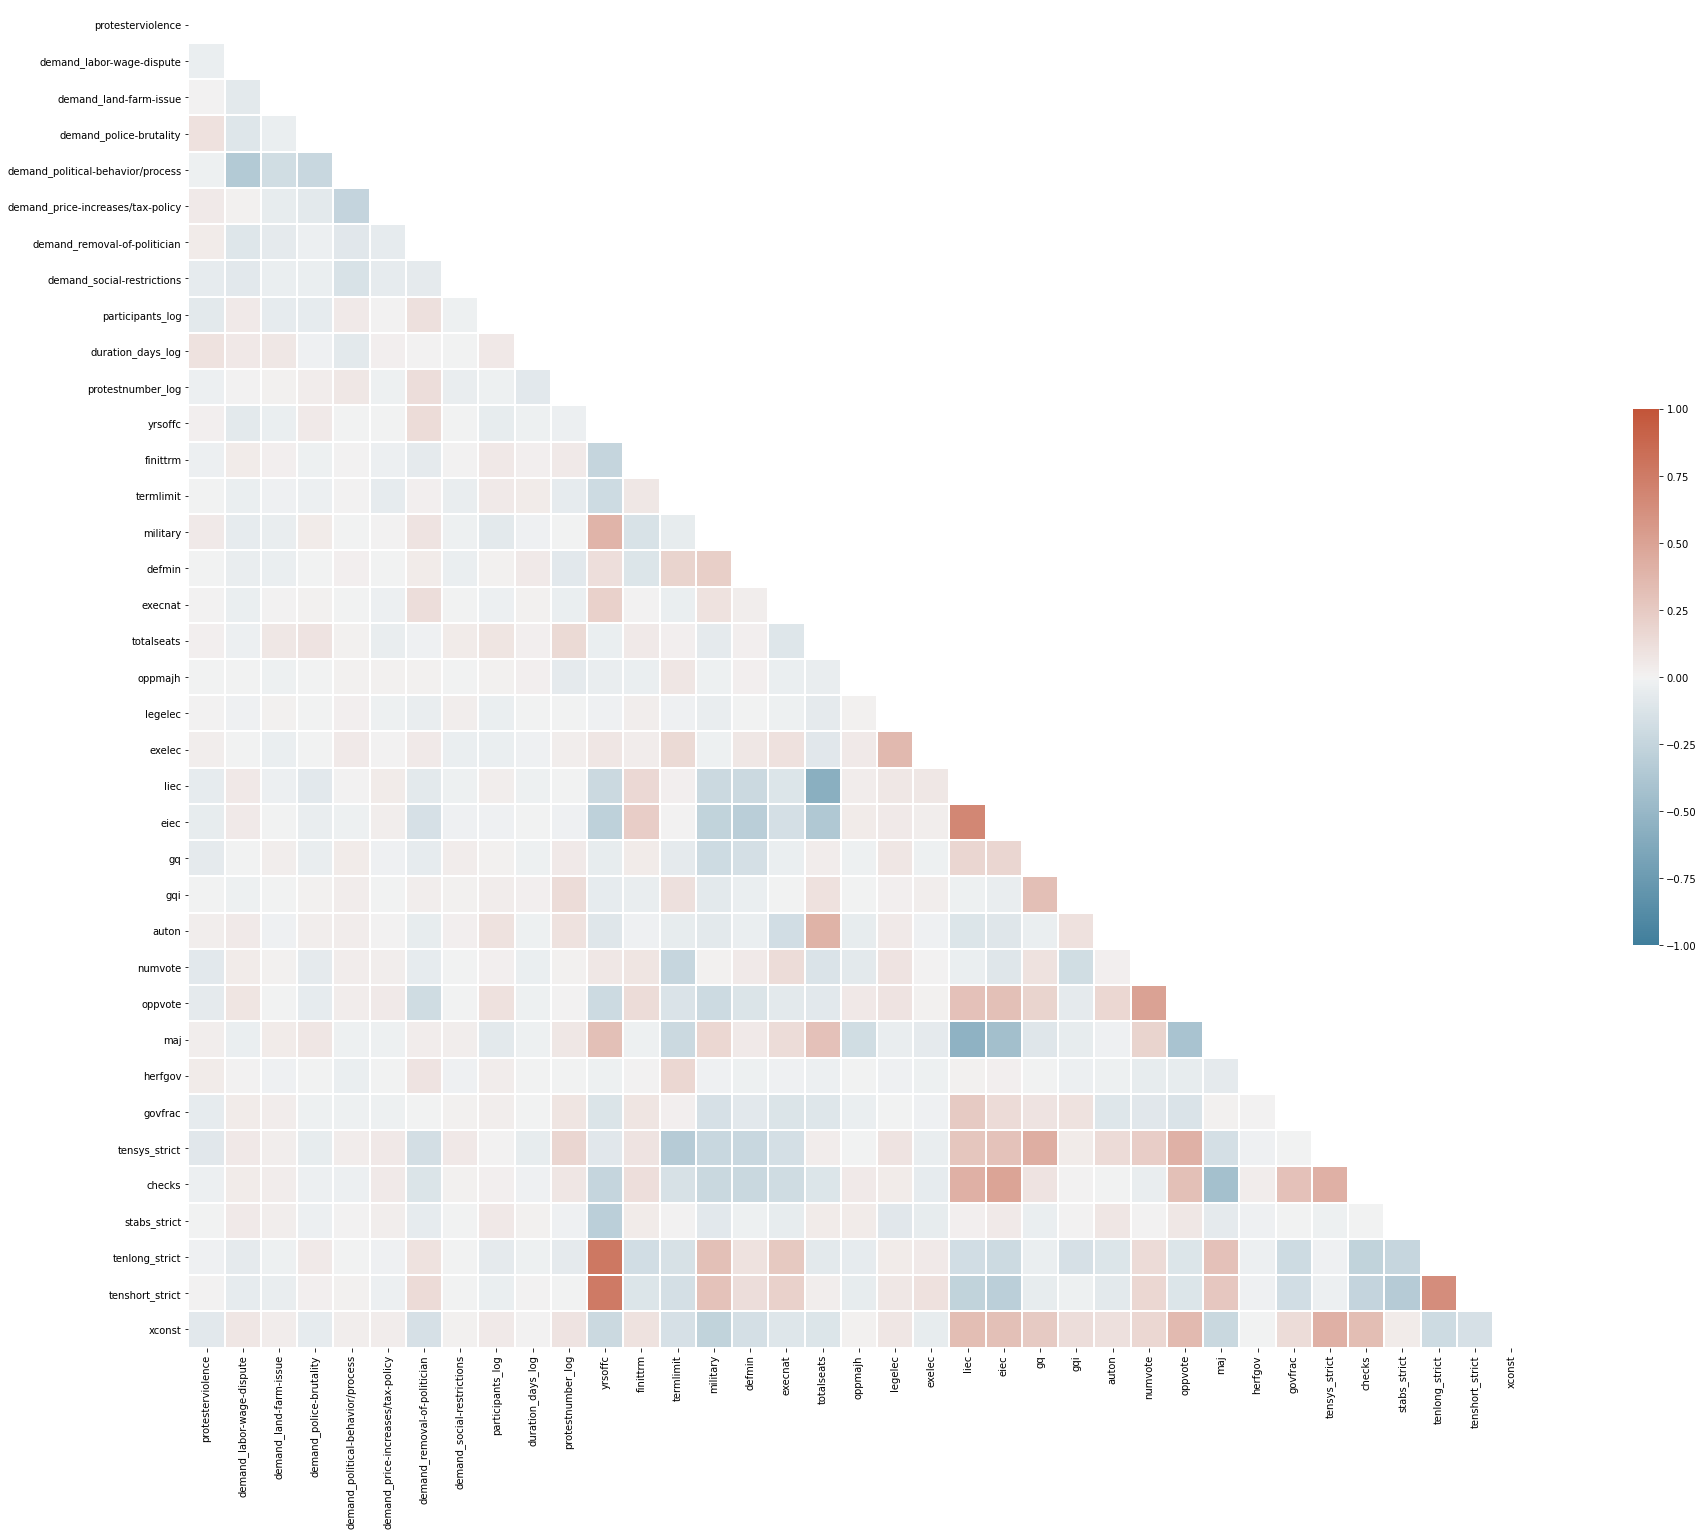

,cc
pairs,
"(protesterviolence, protesterviolence)",1.000000
"(yrsoffc, tenlong_strict)",0.780163
"(tenshort_strict, yrsoffc)",0.765382
"(liec, eiec)",0.674035
"(tenlong_strict, tenshort_strict)",0.633976
"(liec, totalseats)",0.573247
"(liec, maj)",0.553506
"(oppvote, numvote)",0.504882


Features with correlation higher than 0.5:


In [16]:
calculate_collinearity(model_inputs, min_threshold=0.5)

#### Check for high Variance Inflation Factors (VIFs), indicating problematic collinearity

Note the correlation between *liec* and *eiec* in the above heatmap is the highest on the plot. Investigate this relationship alongside other features using VIF analysis.

Note that the VIF threshold of 10 is higher than usual. This is because high multi-collinearity is less of an issue for tree-based models, as this notebook deems the most appropriate. A threshold of 10 ensures that extreme collinearity is addressed while also ensuring that features are not unncessarily dropped, losing valuable predictive information.

In [17]:
# Calculate Variance Inflation Factor for input DataFrame
def calc_vif(df_input):
    # Source: Flatiron School course material
    # https://github.com/learn-co-curriculum/dsc-modeling-your-data

    vif = [variance_inflation_factor(df_input.values, i) for i in range(df_input.shape[1])]
    return list(zip(df_input.columns, vif))

[('protesterviolence', 1.44868299774804),
 ('demand_labor-wage-dispute', 1.6204214619562236),
 ('demand_land-farm-issue', 1.208810302966097),
 ('demand_police-brutality', 1.3395906398870971),
 ('demand_political-behavior/process', 5.513852371701452),
 ('demand_price-increases/tax-policy', 1.3168762166422847),
 ('demand_removal-of-politician', 1.425511446325062),
 ('demand_social-restrictions', 1.1676559446483674),
 ('participants_log', 9.263351416533459),
 ('duration_days_log', 1.1461953736415431),
 ('protestnumber_log', 3.410186100779725),
 ('yrsoffc', 8.37284616777815),
 ('finittrm', 54.41943320661126),
 ('termlimit', 4.873827265679371),
 ('military', 1.5299962092037278),
 ('defmin', 1.474407369303405),
 ('execnat', 1.3426018999607543),
 ('totalseats', 3.771894688181355),
 ('oppmajh', 1.0624530491055708),
 ('legelec', 1.5828221998186602),
 ('exelec', 1.4835143009886813),
 ('liec', 99.23294309707873),
 ('eiec', 64.8298165175228),
 ('gq', 3.084535900311382),
 ('gqi', 1.8876143244248036

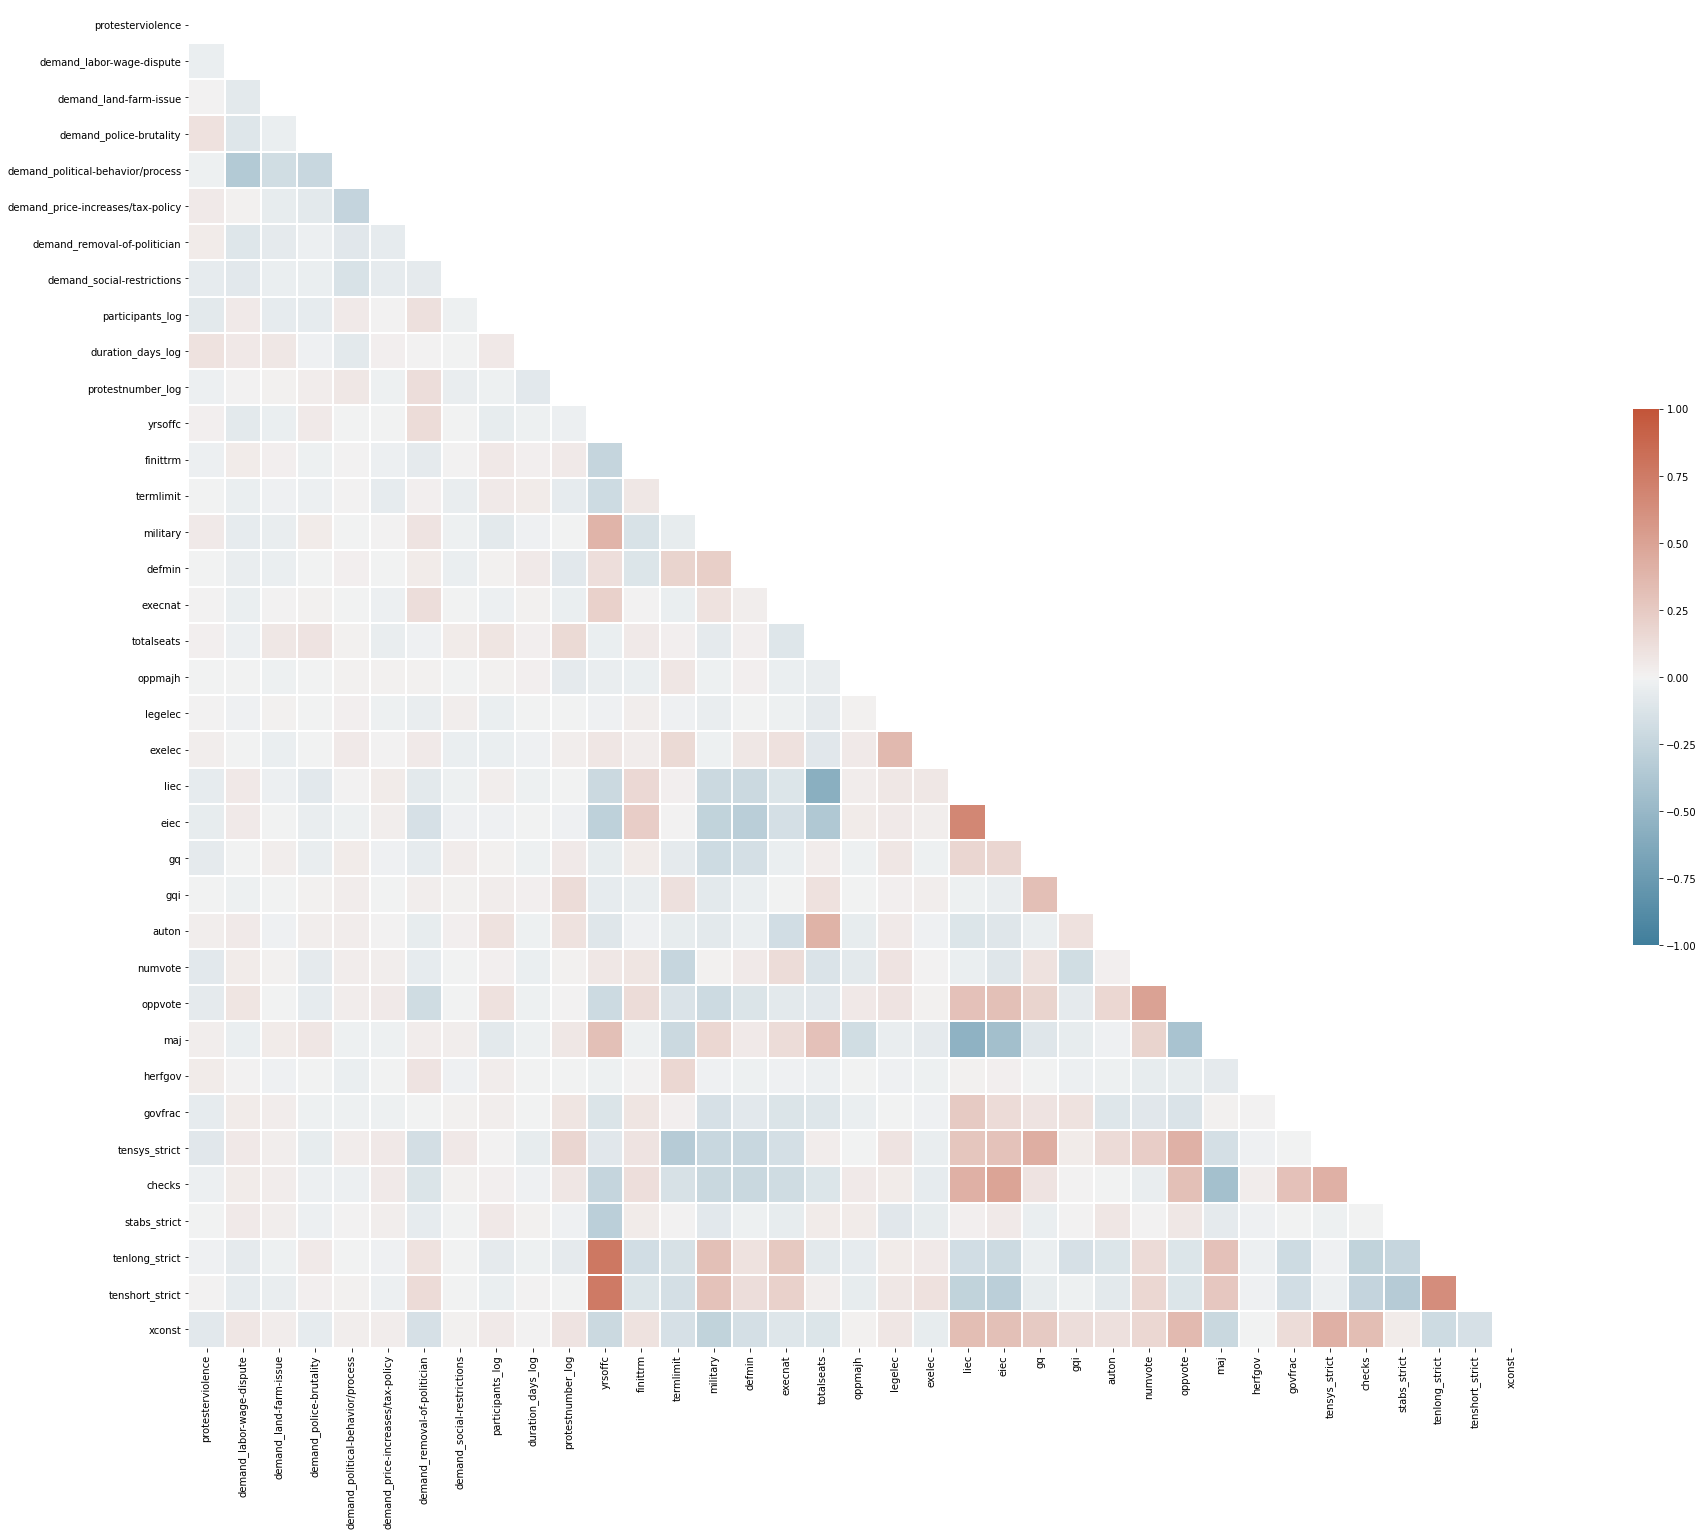

Features with correlation higher than 0.2:


,cc
pairs,
"(protesterviolence, protesterviolence)",1.000000
"(yrsoffc, tenlong_strict)",0.780163
"(tenshort_strict, yrsoffc)",0.765382
"(liec, eiec)",0.674035
"(tenlong_strict, tenshort_strict)",0.633976
...,...
"(yrsoffc, execnat)",0.209019
"(eiec, tenlong_strict)",0.206541
"(oppvote, yrsoffc)",0.204862


In [18]:
# Ignore categoricals for VIF
vif_droppers = ['country', 'region', 'system', 'execrel'] # Categoricals
collinearity_df = model_inputs.drop(vif_droppers, axis=1)

display(calc_vif(collinearity_df))
calculate_collinearity(collinearity_df, min_threshold=0.2, plot=True)

##### Remove *liec*

Reminder of definitions:
- *liec:* legislative index of electoral competitiveness
- *eiec:* executive index of electoral competitiveness

Given the similar nature of these features, collinearity is not surprising. Given the downstream analysis of past models, it was determined that *eiec* has a stronger impact on model performance than *liec*. Drop the latter. 


In [19]:
model_inputs.drop(['liec', 'eiec', 'tenlong_strict', 'tenshort_strict', 'finittrm', 'govfrac', 'oppvote'], axis=1, inplace=True)

[('protesterviolence', 1.4284165923417442),
 ('demand_labor-wage-dispute', 1.5775585041959777),
 ('demand_land-farm-issue', 1.198318309118901),
 ('demand_police-brutality', 1.3113263252488623),
 ('demand_political-behavior/process', 5.182846671644404),
 ('demand_price-increases/tax-policy', 1.29445052765119),
 ('demand_removal-of-politician', 1.3739765526630505),
 ('demand_social-restrictions', 1.1555870540176596),
 ('participants_log', 8.347742330546884),
 ('duration_days_log', 1.1440221138508397),
 ('protestnumber_log', 3.3552785319353164),
 ('yrsoffc', 2.80425614997517),
 ('termlimit', 3.7274704558416283),
 ('military', 1.498776804304648),
 ('defmin', 1.433254004090043),
 ('execnat', 1.2781958948352632),
 ('totalseats', 2.588238035302926),
 ('oppmajh', 1.0557336248410882),
 ('legelec', 1.5578114828080951),
 ('exelec', 1.4671253709952061),
 ('gq', 2.905367989418863),
 ('gqi', 1.8010361525378558),
 ('auton', 1.7968805145686535),
 ('numvote', 3.225797973005871),
 ('maj', 11.97002985103

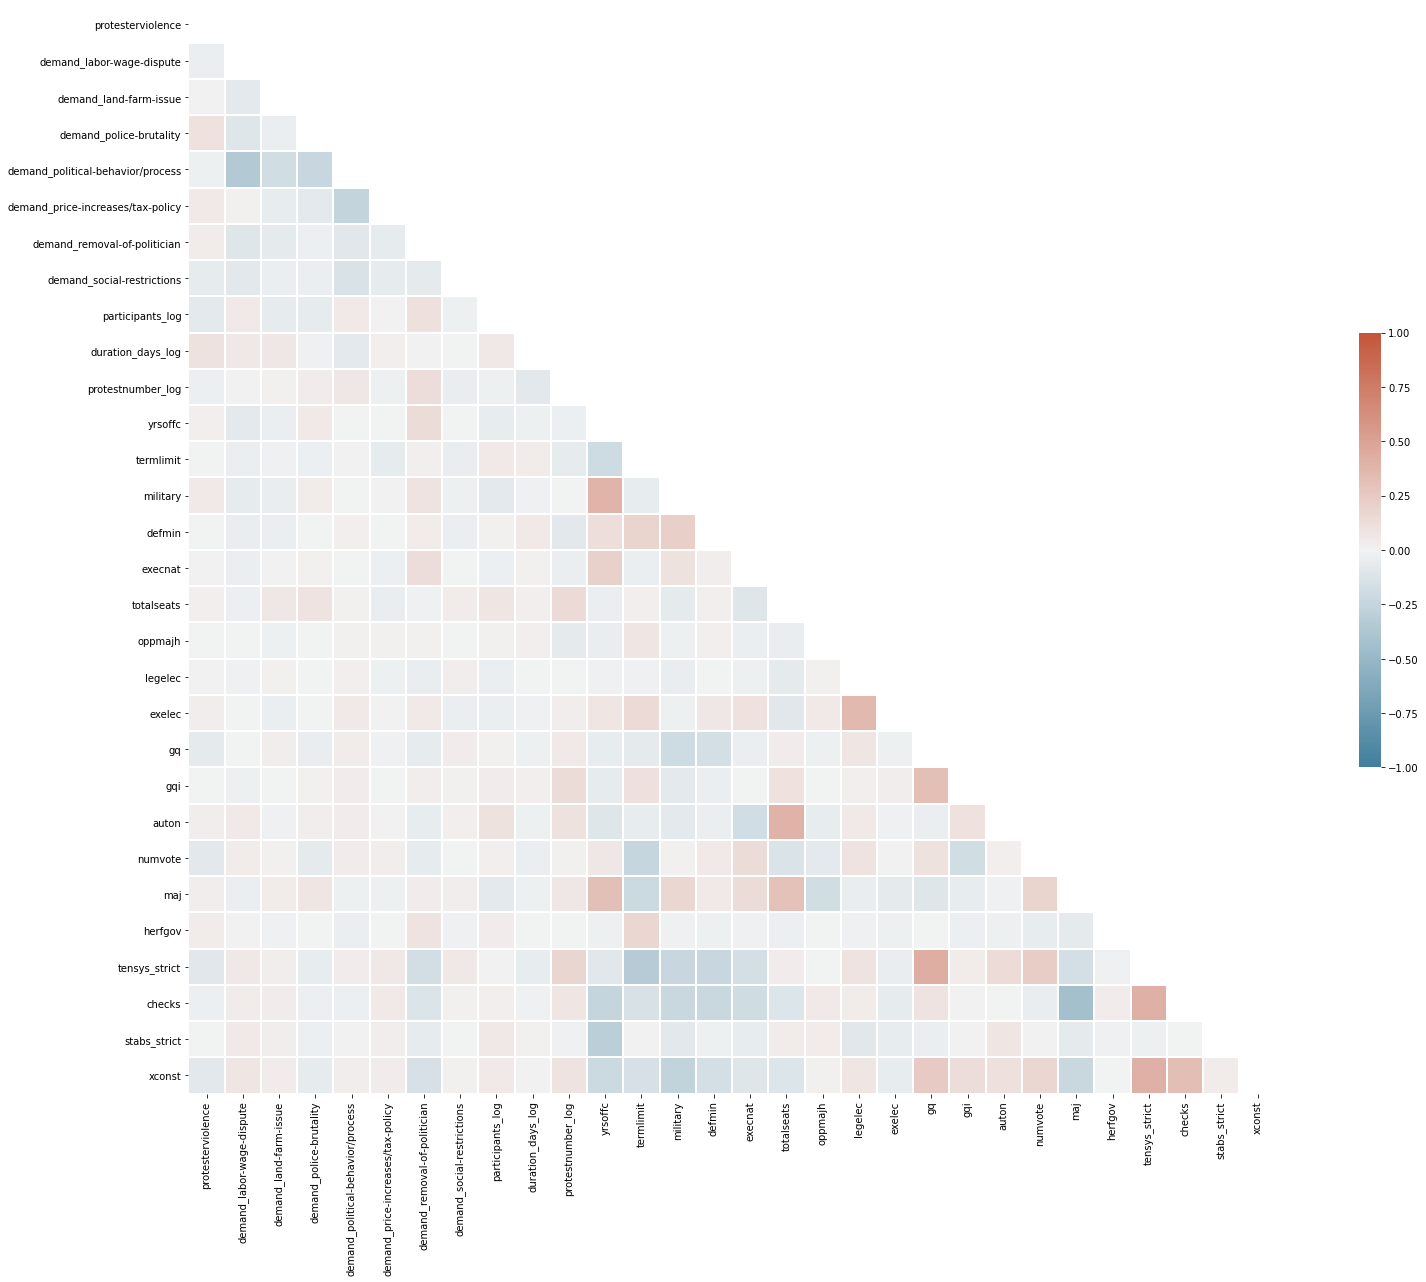

Features with correlation higher than 0.2:


,cc
pairs,
"(protesterviolence, protesterviolence)",1.000000
"(maj, checks)",0.436117
"(gq, tensys_strict)",0.432867
"(checks, tensys_strict)",0.420018
"(tensys_strict, xconst)",0.416724
"(auton, totalseats)",0.402273
"(yrsoffc, military)",0.398234
"(exelec, legelec)",0.364723
"(demand_political-behavior/process, demand_labor-wage-dispute)",0.344554


In [20]:
# Ignore categoricals for VIF
vif_droppers = ['country', 'region', 'system', 'execrel'] # Categoricals
collinearity_df = model_inputs.drop(vif_droppers, axis=1)

display(calc_vif(collinearity_df))
calculate_collinearity(collinearity_df, min_threshold=0.2, plot=True)

---

# Modeling

Given the cleaned and aggregated dataset above, the next section moves into the Modeling phase. Each model type is constructed using elements of encoding, scaling, resampling and hyperparameter optimization.

- One hot encoding was essential given the categorical type of some features
- Standard scaling was essential given the vast array of different numerical feature distributions and ranges. Min-max scaling was considered but proved less effective.
- SMOTE was determined to be essential given the imbalanced nature of the dataset. Only 11% of the target feature values were 1, leaving the other 89% as 0. This is a prime example of the need for resampling, and SMOTE proved highly effective.
- Hyperparameter grid searches are inherently valuable when optimizing a model. Appropriate hyperparameter searches were used for each model type.

The output of each model is provided in terms of four core statistical measures (f1 score, accuracy, precision, and recall), in addition to displaying a confusion matrix for the test data. F1 was selected before the modeling process as the most relevant metric given that it encomasses all possible outcomes, as opposed to the other three metrics which leave out at least one possible outcome from their evaluation. 

### Train-test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(model_inputs, target, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.3)

### Define models and parameter grids

Define all models and grids in one place. A pipeline structure is created such that each of these models can be run with the below-defined hyperparameter tuning grids alongside their resampling, scaling and encoding. This allows for minimal repetition in code and a consistent structure.

In [22]:
# Set parameter grid to search across
grid_bay = {'model__var_smoothing': [1e-9]}

grid_log = {'model__C': np.logspace(-1, 5, 10)}

grid_dt = {
    'model__max_depth': [3, 5, 7], 
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10]} 

grid_rf = {
    'model__n_estimators': [25, 75, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

grid_knn = {
    'model__leaf_size': [25, 50, 75],
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']}

grid_ada = {
    'model__n_estimators': [50, 200],
    'model__learning_rate': [1, 0.5, 0.25]}

grid_xgb = {
    'model__learning_rate': [0.01, 0.1, 0.25, 0.5],
    'model__max_depth': [8, 10, 12, 14],
    'model__subsample': [0.4, 0.7, 1],
    'model__n_estimators': [100, 200, 300, 400, 500]}


np.random.seed(RANDOM_STATE)
model_bay = GaussianNB()
model_log = LogisticRegression(max_iter=5000)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_ada = AdaBoostClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                          random_state=RANDOM_STATE)

grids = [grid_bay, grid_log, grid_dt, grid_rf, grid_knn, grid_ada, grid_xgb]
models = [model_bay, model_log, model_dt, model_rf, model_knn, model_ada, model_xgb]

#### Pipeline function

This high-level function wraps all the different components of the model pipeline into one location, applying one-hot encoding, standard scaling, smote resampling, and grid searches to the input model. It also outputs performance in the form of standard metrics and a confusion matrix.

In [23]:
def create_pipeline_and_run(model, grid, metric='accuracy'):
    np.random.seed(RANDOM_STATE)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = StandardScaler()
    smote = SMOTE(random_state=RANDOM_STATE)

    selector_object = make_column_selector(dtype_exclude='number')
    selector_numeric = make_column_selector(dtype_include='number')
    transformer = make_column_transformer((ohe, selector_object),
                                         (scaler, selector_numeric))


    pipe = Pipeline([('transformer', transformer),
                     ('smote', smote), 
                     ('model', model)])

    # Instantiate and fit grid search object
    grid = GridSearchCV(pipe, grid, scoring='f1', cv=10)
    grid.fit(x_train, y_train.values.ravel())
    pred = grid.best_estimator_.predict(x_test)
    
    
    print(f'{model}:')
    print_scores(pred, y_test)
    
    # Confusion matrix
    plt.figure()
    plot_confusion_matrix(grid.best_estimator_, x_test, y_test)
    plt.show();
    
    return grid.best_estimator_

#### Dummy classifier as performance baseline

In [24]:
for strategy in ["stratified", "uniform", "most_frequent"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    
    print(f'DUMMY SCORE ({strategy}):')
    pred = dummy_clf.predict(x_test)
    print_scores(pred, y_test)

DUMMY SCORE (stratified):
- f1: 0.08752735229759301
- accuracy: 0.8826013513513513
- precision: 0.08658008658008658
- recall: 0.08849557522123894
DUMMY SCORE (uniform):
- f1: 0.11536597188560349
- accuracy: 0.48620495495495497
- precision: 0.06477953184540011
- recall: 0.5265486725663717
DUMMY SCORE (most_frequent):
- f1: 0.0
- accuracy: 0.9363738738738738
- precision: 0.0
- recall: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


### Run *all models* defined above

Run this cell to output the performance of all above-defined models in one place for a side-by-side comparison

GaussianNB():
- f1: 0.18098415346121766
- accuracy: 0.44707207207207206
- precision: 0.09990791896869244
- recall: 0.9601769911504425


<Figure size 432x288 with 0 Axes>

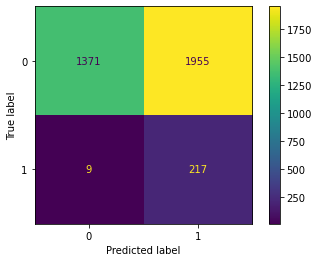

LogisticRegression(max_iter=5000):
- f1: 0.31860036832412525
- accuracy: 0.7916666666666666
- precision: 0.20116279069767443
- recall: 0.7654867256637168


<Figure size 432x288 with 0 Axes>

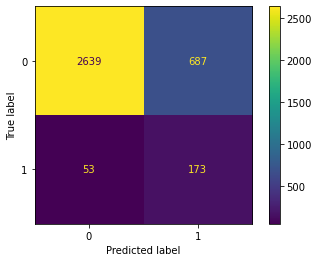

DecisionTreeClassifier():
- f1: 0.5975609756097561
- accuracy: 0.9442567567567568
- precision: 0.5526315789473685
- recall: 0.6504424778761062


<Figure size 432x288 with 0 Axes>

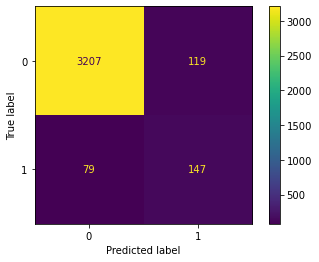

RandomForestClassifier():
- f1: 0.6496519721577726
- accuracy: 0.9574887387387387
- precision: 0.6829268292682927
- recall: 0.6194690265486725


<Figure size 432x288 with 0 Axes>

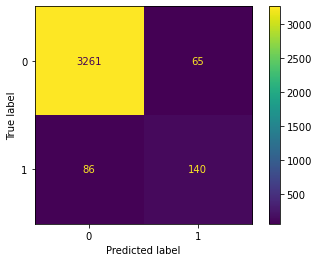

KNeighborsClassifier():
- f1: 0.4137055837563452
- accuracy: 0.8699324324324325
- precision: 0.2900355871886121
- recall: 0.7212389380530974


<Figure size 432x288 with 0 Axes>

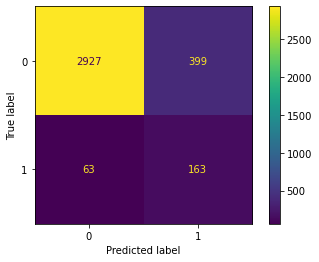

AdaBoostClassifier(random_state=2021):
- f1: 0.2868020304568528
- accuracy: 0.8417792792792793
- precision: 0.20106761565836298
- recall: 0.5


<Figure size 432x288 with 0 Axes>

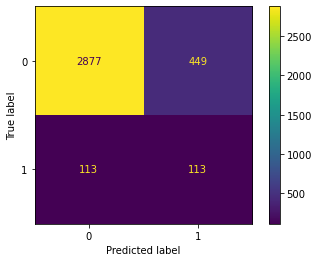

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=2021, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None):
- f1: 0.7529976019184652
- accuracy: 0.9710022522522522
- precision: 0.8219895287958116
- recall: 0.6946902654867256


<Figure size 432x288 with 0 Axes>

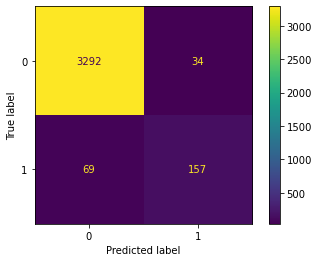

In [25]:
pipes = []
for grid, model in zip(grids, models):
    pipe = create_pipeline_and_run(model, grid)
    pipes.append(pipe)

### Run *only one* model

Choose which model to run in the below cell (this cell is only used for iterative testing and investigating model specifics without running all models)

In [26]:
# Uncomment and run to look at one model separately
#xgb = create_pipeline_and_run(model_xgb, grid_xgb);

##### Print optimal model hyperparameters

In [27]:
xgb = pipes[-1] # Since it is the last model in pipes
print(xgb.steps[2])

('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, random_state=2021, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None))


#### Test model on test dataset

XG boost proves to be the highest performing model. Test its performance on the test dataset.

- f1: 0.7529976019184652
- accuracy: 0.9710022522522522
- precision: 0.8219895287958116
- recall: 0.6946902654867256


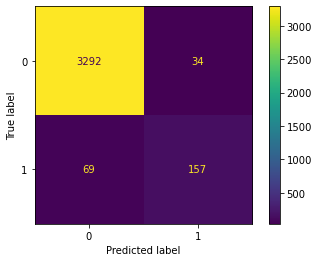

In [28]:
# Predict output
pred = xgb.predict(x_test)

# Show performance
print_scores(pred, y_test)
plot_confusion_matrix(xgb, x_test, y_test);

##### Plot confusion matrices

- f1: 0.7529976019184652
- accuracy: 0.9710022522522522
- precision: 0.8219895287958116
- recall: 0.6946902654867256


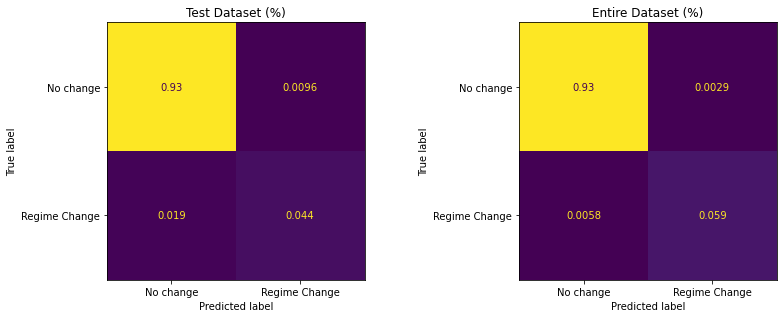

In [29]:
# Predict output
pred = xgb.predict(x_test)

# Show performance
print_scores(pred, y_test)

# Plot test data and full data performance
labels = ['No change', 'Regime Change']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
plt.subplots_adjust(wspace=0.6, hspace=None)
axes[0].set_title('Test Dataset (%)')
axes[1].set_title('Entire Dataset (%)')

plot_confusion_matrix(xgb, x_test, y_test, 
                      ax=axes[0], 
                      display_labels=labels, 
                      colorbar=False, 
                      normalize='all')

plot_confusion_matrix(xgb, model_inputs, target, 
                      ax=axes[1], 
                      display_labels=labels, 
                      colorbar=False, 
                      normalize='all');

plt.savefig('../images/confusion_matrices.png')

### Feature importance

Evaluate the feature importance in the top-performing model

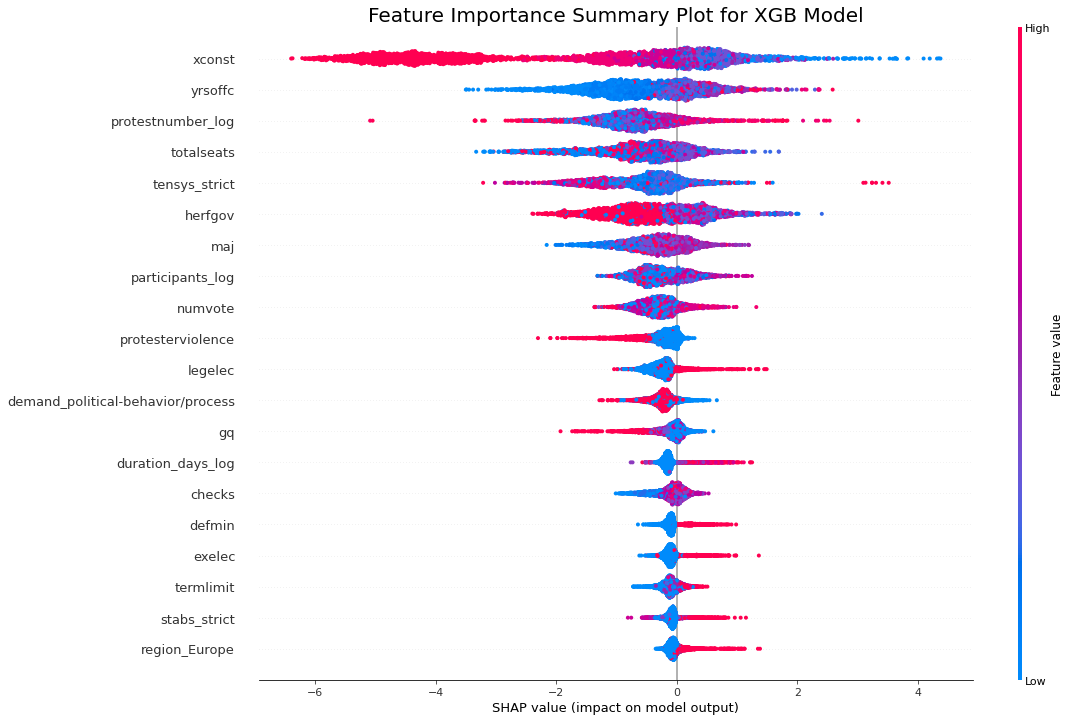

In [30]:
# SHAP summary plot for XGB
produce_shap_plot(x_train, y_train, x_test, y_test, clone(xgb), 
                  title='Feature Importance Summary Plot for XGB Model', 
                  savepath = '../images/shap_summary_plot.png');

In [31]:
# SHAP bar plot for XGB model
x_tr_manual, y_tr_manual, x_te_manual = get_shap_df(x_train, y_train, x_test)
model = model_xgb.steps[2][1]

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(x_te_manual)

# SHAP bar plot for XGB model
plt.figure()
plt.title('Feature Importance Bar Plot for XGB Model', fontsize=20)
shap.plots.bar(shap_values, max_display=20, show=False)
plt.savefig('../images/shap_bar_plot.png');

AttributeError: 'XGBClassifier' object has no attribute 'steps'

### Permutation Feature Importance

Source: https://scikit-learn.org/stable/modules/permutation_importance.html

In [ ]:
# Subsequent functions can't handle categoricals so 
# fit dataframe outside pipeline
model = xgb.steps[2][1]
x_tr, y_tr, x_te = get_shap_df(x_train, y_train, x_test)
model.fit(x_tr, y_tr);



r = permutation_importance(model, x_te, y_test, 
                           n_repeats=30, 
                           random_state=RANDOM_STATE)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 3 * r.importances_std[i] > 0:
        #print(f"{df_train.feature_names[i]:<8}"
        print(f"{x_tr.columns[i]} "
              f"{r.importances_mean[i]:.3f}")

## Export final datasets and models for use in other notebooks
The final, cleaned dataframe with features selected and engineered is exported via SQL. Three selected final, fitted models are stored as Pickle files for use in the Final Presentation notebook.

##### Export data via SQL

In [ ]:
engine = create_engine('sqlite:///../data/processed/all_data.db')

model_data = pd.concat([model_inputs, target], axis=1)

with engine.begin() as connection:
    model_data.to_sql(name='all_modeled_data', 
                      con=connection, 
                      if_exists='replace', 
                      index=False)

##### Export models via Pickle

In [ ]:
# Save fitted Logistic Regression
with open('../data/processed/model_logreg.pickle', 'wb') as f:
    pickle.dump(pipes[1], f)

# Save fitted Random Forest
with open('../data/processed/model_rf.pickle', 'wb') as f:
    pickle.dump(pipes[3], f)

# # Save fitted XG Boost
with open('../data/processed/model_xgb.pickle', 'wb') as f:
    pickle.dump(pipes[-1], f)

In [ ]:
print(x_train.shape)
x_train.info()